# Problem 1: Basics of Neural Networks
* <b>Learning Objective:</b> In this problem, you are asked to implement a basic multi-layer fully connected neural network from scratch, including forward and backward passes of certain essential layers, to perform an image classification task on CIFAR-10 dataset. You need to implement essential functions in different indicated python files under directory `lib`.
* <b>Provided Code:</b> We provide the skeletons of classes you need to complete. Forward checking and gradient checkings are provided for verifying your implementation as well.
* <b>TODOs:</b> You are asked to implement the forward passes and backward passes for standard layers and loss functions, various widely-used optimizers, and part of the training procedure. And finally we want you to train a network from scratch on your own. Also, there are inline questions you need to answer. See `README.md` to set up your environment.

In [1]:
from lib.mlp.fully_conn import *
from lib.mlp.layer_utils import *
from lib.mlp.datasets import *
from lib.mlp.train import *
from lib.grad_check import *
from lib.optim import *
import numpy as np
import matplotlib.pyplot as plt
import pdb

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading the data (CIFAR-10)
Run the following code block to download CIFAR-10 dataset and load in the properly splitted CIFAR-10 data. The script `get_datasets.sh` use `wget` to download the CIFAR-10 dataset. If you have a trouble with executing `get_datasets.sh`, you can manually download the dataset and extract files.

In [2]:
!./get_datasets.sh
# !get_datasets.sh for windows users

./get_datasets.sh: line 2: wget: command not found
tar: Error opening archive: Failed to open 'data/cifar-10-python.tar.gz'
rm: data/cifar-10-python.tar.gz: No such file or directory


Load the dataset.

In [2]:
data = CIFAR10_data()
for k, v in data.items():
    print ("Name: {} Shape: {}".format(k, v.shape))

Name: data_train Shape: (49000, 3, 32, 32)
Name: labels_train Shape: (49000,)
Name: data_val Shape: (1000, 3, 32, 32)
Name: labels_val Shape: (1000,)
Name: data_test Shape: (1000, 3, 32, 32)
Name: labels_test Shape: (1000,)


## Implement Standard Layers
You will now implement all the following standard layers commonly seen in a fully connected neural network (aka multi-layer perceptron, MLP). Please refer to the file `lib/mlp/layer_utils.py`. Take a look at each class skeleton, and we will walk you through the network layer by layer. We provide results of some examples we pre-computed for you for checking the forward pass, and also the gradient checking for the backward pass.

## FC Forward [2pt]
In the class skeleton `flatten` and `fc` in `lib/mlp/layer_utils.py`, please complete the forward pass in function `forward`. The input to the `fc` layer may not be of dimension (batch size, features size), it could be an image or any higher dimensional data. We want to convert the input to have a shape of (batch size, features size). Make sure that you handle this dimensionality issue. 

In [3]:
%reload_ext autoreload

# Test the fc forward function
input_bz = 3 # batch size
input_dim = (7, 6, 4)
output_dim = 4

input_size = input_bz * np.prod(input_dim)
weight_size = output_dim * np.prod(input_dim)

flatten_layer = flatten(name="flatten_test")
single_fc = fc(np.prod(input_dim), output_dim, init_scale=0.02, name="fc_test")

x = np.linspace(-0.1, 0.4, num=input_size).reshape(input_bz, *input_dim)
w = np.linspace(-0.2, 0.2, num=weight_size).reshape(np.prod(input_dim), output_dim)
b = np.linspace(-0.3, 0.3, num=output_dim)

single_fc.params[single_fc.w_name] = w
single_fc.params[single_fc.b_name] = b

out = single_fc.forward(flatten_layer.forward(x))

correct_out = np.array([[0.63910291, 0.83740057, 1.03569824, 1.23399591],
                        [0.61401587, 0.82903823, 1.04406058, 1.25908294],
                        [0.58892884, 0.82067589, 1.05242293, 1.28416997]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-8
print ("Difference: ", rel_error(out, correct_out))

Difference:  4.02601593296122e-09


## FC Backward [2pt]
Please complete the function `backward` as the backward pass of the `flatten` and `fc` layers. Follow the instructions in the comments to store gradients into the predefined dictionaries in the attributes of the class. Parameters of the layer are also stored in the predefined dictionary.

In [4]:
%reload_ext autoreload

# Test the fc backward function
inp = np.random.randn(15, 2, 2, 3)
w = np.random.randn(12, 15)
b = np.random.randn(15)
dout = np.random.randn(15, 15)

flatten_layer = flatten(name="flatten_test")
x = flatten_layer.forward(inp)
single_fc = fc(np.prod(x.shape[1:]), 15, init_scale=5e-2, name="fc_test")
single_fc.params[single_fc.w_name] = w
single_fc.params[single_fc.b_name] = b

dx_num = eval_numerical_gradient_array(lambda x: single_fc.forward(x), x, dout)
dw_num = eval_numerical_gradient_array(lambda w: single_fc.forward(x), w, dout)
db_num = eval_numerical_gradient_array(lambda b: single_fc.forward(x), b, dout)

out = single_fc.forward(x)
dx = single_fc.backward(dout)
dw = single_fc.grads[single_fc.w_name]
db = single_fc.grads[single_fc.b_name]
dinp = flatten_layer.backward(dx)

# The error should be around 1e-9
print("dx Error: ", rel_error(dx_num, dx))
# The errors should be around 1e-10
print("dw Error: ", rel_error(dw_num, dw))
print("db Error: ", rel_error(db_num, db))
# The shapes should be same
print("dinp Shape: ", dinp.shape, inp.shape)

dx Error:  5.50119765398458e-10
dw Error:  1.2023477845570107e-09
db Error:  3.2022714766601866e-10
dinp Shape:  (15, 2, 2, 3) (15, 2, 2, 3)


## ReLU Forward [2pt]
In the class skeleton `relu` in `lib/mlp/layer_utils.py`, please complete the `forward` pass.

In [5]:
%reload_ext autoreload

# Test the relu forward function
x = np.linspace(-1.5, 1.5, num=12).reshape(3, 4)
relu_f = relu(name="relu_f")

out = relu_f.forward(x)

correct_out = np.array([[0.,          0.,         0.,         0.        ],
                        [0.,          0.,         0.13636364, 0.40909091],
                        [0.68181818,  0.95454545, 1.22727273, 1.5      ]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-7
print ("Difference: ", rel_error(out, correct_out))

Difference:  1.3333333629634122e-08


## ReLU Backward [2pt]
Please complete the `backward` pass of the class `relu`.

In [6]:
%reload_ext autoreload
# Test the relu backward function
x = np.random.randn(15, 15)
dout = np.random.randn(*x.shape)
relu_b = relu(name="relu_b")

dx_num = eval_numerical_gradient_array(lambda x: relu_b.forward(x), x, dout)

out = relu_b.forward(x)
dx = relu_b.backward(dout)

# The error should not be larger than 1e-10
print ("dx Error: ", rel_error(dx_num, dx))

dx Error:  3.2756299318403416e-12


## Dropout Forward [2pt]
In the class `dropout` in `lib/mlp/layer_utils.py`, please complete the `forward` pass.  
Remember that the dropout is only applied during training phase, you should pay attention to this while implementing the function.
##### Important Note1: The probability argument input to the function is the "keep probability": probability that each activation is kept.
##### Important Note2: If the keep_prob is set to 0, make it as no dropout.

In [7]:
%reload_ext autoreload

x = np.random.randn(100, 100) + 5.0

print ("----------------------------------------------------------------")
for p in [0, 0.25, 0.50, 0.75, 1]:
    dropout_f = dropout(keep_prob=p)
    out = dropout_f.forward(x, True)
    out_test = dropout_f.forward(x, False)
    
    # Mean of output should be similar to mean of input
    # Means of output during training time and testing time should be similar
    print ("Dropout Keep Prob = ", p)
    print ("Mean of input: ", x.mean())
    print ("Mean of output during training time: ", out.mean())
    print ("Mean of output during testing time: ", out_test.mean())
    print ("Fraction of output set to zero during training time: ", (out == 0).mean())
    print ("Fraction of output set to zero during testing time: ", (out_test == 0).mean())
    print ("----------------------------------------------------------------")

----------------------------------------------------------------
Dropout Keep Prob =  0
Mean of input:  4.980433760562105
Mean of output during training time:  4.980433760562105
Mean of output during testing time:  4.980433760562105
Fraction of output set to zero during training time:  0.0
Fraction of output set to zero during testing time:  0.0
----------------------------------------------------------------
Dropout Keep Prob =  0.25
Mean of input:  4.980433760562105
Mean of output during training time:  5.079136058059391
Mean of output during testing time:  4.980433760562105
Fraction of output set to zero during training time:  0.7442
Fraction of output set to zero during testing time:  0.0
----------------------------------------------------------------
Dropout Keep Prob =  0.5
Mean of input:  4.980433760562105
Mean of output during training time:  5.055055426165979
Mean of output during testing time:  4.980433760562105
Fraction of output set to zero during training time:  0.4925
Fr

## Dropout Backward [2pt]
Please complete the `backward` pass. Again remember that the dropout is only applied during training phase, handle this in the backward pass as well.

In [8]:
%reload_ext autoreload

x = np.random.randn(5, 5) + 5
dout = np.random.randn(*x.shape)

keep_prob = 0.75
dropout_b = dropout(keep_prob, seed=100)
out = dropout_b.forward(x, True, seed=1)
dx = dropout_b.backward(dout)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_b.forward(xx, True, seed=1), x, dout)

# The error should not be larger than 1e-10
print ('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  3.0031121044854954e-11


## Testing cascaded layers: FC + ReLU [2pt]
Please find the `TestFCReLU` function in `lib/mlp/fully_conn.py`. <br />
You only need to complete a few lines of code in the TODO block. <br />
Please design an `Flatten -> FC -> ReLU` network where the parameters of them match the given x, w, and b. <br />
Please insert the corresponding names you defined for each layer to param_name_w, and param_name_b respectively. Here you only modify the param_name part, the `_w`, and `_b` are automatically assigned during network setup 

In [9]:
%reload_ext autoreload

x = np.random.randn(3, 4, 5)  # the input features
w = np.random.randn(20, 10)   # the weight of fc layer
b = np.random.randn(10)       # the bias of fc layer
dout = np.random.randn(3, 10) # the gradients to the output, notice the shape

tiny_net = TestFCReLU()

###################################################
# TODO: param_name should be replaced accordingly #
###################################################
tiny_net.net.assign("fc_w", w)
tiny_net.net.assign("fc_b", b)
###################################################
#                END OF YOUR CODE                 #
###################################################

out = tiny_net.forward(x)
dx = tiny_net.backward(dout)

###################################################
# TODO: param_name should be replaced accordingly #
###################################################
dw = tiny_net.net.get_grads("fc_w")
db = tiny_net.net.get_grads("fc_b")
###################################################
#                END OF YOUR CODE                 #
###################################################

dx_num = eval_numerical_gradient_array(lambda x: tiny_net.forward(x), x, dout)
dw_num = eval_numerical_gradient_array(lambda w: tiny_net.forward(x), w, dout)
db_num = eval_numerical_gradient_array(lambda b: tiny_net.forward(x), b, dout)

# The errors should not be larger than 1e-7
print ("dx error: ", rel_error(dx_num, dx))
print ("dw error: ", rel_error(dw_num, dw))
print ("db error: ", rel_error(db_num, db))

dx error:  1.8245508188299786e-10
dw error:  2.731692355040203e-09
db error:  8.930864073524232e-11


## SoftMax Function and Loss Layer [2pt]
In the `lib/mlp/layer_utils.py`, please first complete the function `softmax`, which will be used in the function `cross_entropy`. Then, implement `corss_entropy` using `softmax`.
Please refer to the lecture slides of the mathematical expressions of the cross entropy loss function, and complete its forward pass and backward pass.

In [10]:
%reload_ext autoreload

num_classes, num_inputs = 6, 100
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

test_loss = cross_entropy()

dx_num = eval_numerical_gradient(lambda x: test_loss.forward(x, y), x, verbose=False)

loss = test_loss.forward(x, y)
dx = test_loss.backward()

# Test softmax_loss function. Loss should be around 1.792
# and dx error should be at the scale of 1e-8 (or smaller)
print ("Cross Entropy Loss: ", loss)
print ("dx error: ", rel_error(dx_num, dx))

Cross Entropy Loss:  1.7917014160179756
dx error:  1.0311439728897416e-08


## Test a Small Fully Connected Network [2pt]
Please find the `SmallFullyConnectedNetwork` function in `lib/mlp/fully_conn.py`. <br />
Again you only need to complete few lines of code in the TODO block. <br />
Please design an `FC --> ReLU --> FC --> ReLU` network where the shapes of parameters match the given shapes. <br />
Please insert the corresponding names you defined for each layer to param_name_w, and param_name_b respectively. <br />
Here you only modify the param_name part, the `_w`, and `_b` are automatically assigned during network setup. 

In [11]:
%reload_ext autoreload

seed = 1234
np.random.seed(seed=seed)

model = SmallFullyConnectedNetwork()
loss_func = cross_entropy()

N, D, = 4, 4  # N: batch size, D: input dimension
H, C  = 30, 7 # H: hidden dimension, C: output dimension
std = 0.02
x = np.random.randn(N, D)
y = np.random.randint(C, size=N)

print ("Testing initialization ... ")

###################################################
# TODO: param_name should be replaced accordingly #
###################################################
w1_std = abs(model.net.get_params("sfcnfc1_w").std() - std)
b1 = model.net.get_params("sfcnfc1_b").std()
w2_std = abs(model.net.get_params("sfcnfc2_w").std() - std)
b2 = model.net.get_params("sfcnfc2_b").std()
###################################################
#                END OF YOUR CODE                 #
###################################################

assert w1_std < std / 10, "First layer weights do not seem right"
assert np.all(b1 == 0), "First layer biases do not seem right"
assert w2_std < std / 10, "Second layer weights do not seem right"
assert np.all(b2 == 0), "Second layer biases do not seem right"
print ("Passed!")

print ("Testing test-time forward pass ... ")
w1 = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
w2 = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
b1 = np.linspace(-0.1, 0.9, num=H)
b2 = np.linspace(-0.9, 0.1, num=C)

###################################################
# TODO: param_name should be replaced accordingly #
###################################################
model.net.assign("sfcnfc1_w", w1)
model.net.assign("sfcnfc1_b", b1)
model.net.assign("sfcnfc2_w", w2)
model.net.assign("sfcnfc2_b", b2)
###################################################
#                END OF YOUR CODE                 #
###################################################

feats = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.forward(feats)
correct_scores = np.asarray([[4.20670862, 4.87188359, 5.53705856, 6.20223352, 6.86740849, 7.53258346, 8.19775843],
                             [4.74826036, 5.35984681, 5.97143326, 6.58301972, 7.19460617, 7.80619262, 8.41777907],
                             [5.2898121,  5.84781003, 6.40580797, 6.96380591, 7.52180384, 8.07980178, 8.63779971],
                             [5.83136384, 6.33577326, 6.84018268, 7.3445921,  7.84900151, 8.35341093, 8.85782035]])
scores_diff = np.sum(np.abs(scores - correct_scores))
assert scores_diff < 1e-6, "Your implementation might went wrong!"
print ("Passed!")

print ("Testing the loss ...",)
y = np.asarray([0, 5, 1, 4])
loss = loss_func.forward(scores, y)
dLoss = loss_func.backward()
correct_loss = 2.90181552716
assert abs(loss - correct_loss) < 1e-10, "Your implementation might went wrong!"
print ("Passed!")

print ("Testing the gradients (error should be no larger than 1e-6) ...")
din = model.backward(dLoss)
for layer in model.net.layers:
    if not layer.params:
        continue
    for name in sorted(layer.grads):
        f = lambda _: loss_func.forward(model.forward(feats), y)
        grad_num = eval_numerical_gradient(f, layer.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, layer.grads[name])))

Testing initialization ... 
Passed!
Testing test-time forward pass ... 
Passed!
Testing the loss ...
Passed!
Testing the gradients (error should be no larger than 1e-6) ...
sfcnfc1_b relative error: 2.85e-09
sfcnfc1_w relative error: 5.01e-09
sfcnfc2_b relative error: 4.33e-07
sfcnfc2_w relative error: 2.59e-09


## Test a Fully Connected Network regularized with Dropout [2pt]
Please find the `DropoutNet` function in `fully_conn.py` under `lib/mlp` directory. <br />
For this part you don't need to design a new network, just simply run the following test code. <br />
If something goes wrong, you might want to double check your dropout implementation.

In [12]:
%reload_ext autoreload

seed = 1234
np.random.seed(seed=seed)

N, D, C = 3, 15, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for keep_prob in [0, 0.25, 0.5]:
    np.random.seed(seed=seed)
    print ("Dropout p =", keep_prob)
    model = DropoutNet(keep_prob=keep_prob, seed=seed)
    loss_func = cross_entropy()
    output = model.forward(X, True, seed=seed)
    loss = loss_func.forward(output, y)
    dLoss = loss_func.backward()
    dX = model.backward(dLoss)
    grads = model.net.grads

    print ("Error of gradients should be around or less than 1e-5")
    for name in sorted(grads):
        if name not in model.net.params.keys():
            continue
        f = lambda _: loss_func.forward(model.forward(X, True, seed=seed), y)
        grad_num = eval_numerical_gradient(f, model.net.params[name], verbose=False, h=1e-5)
        print ("{} relative error: {}".format(name, rel_error(grad_num, grads[name])))
    print ()

Dropout p = 0
Error of gradients should be around or less than 1e-5
fc1_b relative error: 6.952798133119647e-08
fc1_w relative error: 1.5987270742145443e-05
fc2_b relative error: 1.557520873278236e-07
fc2_w relative error: 0.00023654295620114692
fc3_b relative error: 1.6904596407923826e-10
fc3_w relative error: 6.34431176039762e-07

Dropout p = 0.25
Error of gradients should be around or less than 1e-5
fc1_b relative error: 1.9921020693142777e-08
fc1_w relative error: 1.5180637259954746e-06
fc2_b relative error: 7.688416889146262e-08
fc2_w relative error: 3.325050324738692e-06
fc3_b relative error: 1.609799375618303e-10
fc3_w relative error: 2.5126126741961968e-08

Dropout p = 0.5
Error of gradients should be around or less than 1e-5
fc1_b relative error: 6.210180150740612e-08
fc1_w relative error: 3.403580650504518e-05
fc2_b relative error: 4.5563186104318545e-09
fc2_w relative error: 2.1112705799381416e-06
fc3_b relative error: 9.57365409177081e-11
fc3_w relative error: 4.65178424310

## Training a Network
In this section, we defined a `TinyNet` class for you to fill in the TODO block in `lib/mlp/fully_conn.py`.
* Here please design a two layer fully connected network with ReLU activation (`Flatten --> FC --> ReLU --> FC`).
* You can adjusting the number of hidden neurons, batch_size, and epochs.
* Please read the `lib/train.py` carefully and complete the TODO blocks in the `train_net` function first. Codes in "Test a Small Fully Connected Network" can be helpful.
* In addition, read how the SGD function is implemented in `lib/optim.py`, you will be asked to complete three other optimization methods in the later sections.

In [13]:
# Arrange the data
data_dict = {
    "data_train": (data["data_train"], data["labels_train"]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

In [14]:
print(data["data_train"].shape)
print(data["labels_train"].shape)

(49000, 3, 32, 32)
(49000,)


### Now train the network to achieve at least 50% validation accuracy [5pt]

In [52]:
%reload_ext autoreload

seed = 123
np.random.seed(seed=seed)

model = TinyNet()
loss_f = cross_entropy()
optimizer = SGD(model.net, 1e-4)

results = None
#############################################################################
# TODO: Use the train_net function you completed to train a network         #
#############################################################################

batch_size = 100
epochs = 25
# lr_decay = 1.0
lr_decay = 0.01
lr_decay_every = 1000

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
results = train_net(data_dict, model, loss_f, optimizer, batch_size, epochs, 
                    lr_decay, lr_decay_every, show_every=1000, verbose=True)
opt_params, loss_hist, train_acc_hist, val_acc_hist = results

(Iteration 1 / 12250) loss: 2.3692941226311963
(Epoch 1 / 25) Training Accuracy: 0.43, Validation Accuracy: 0.424
(Epoch 2 / 25) Training Accuracy: 0.52, Validation Accuracy: 0.442
(Iteration 1001 / 12250) loss: 1.6807085645823046
(Epoch 3 / 25) Training Accuracy: 0.43, Validation Accuracy: 0.454
(Epoch 4 / 25) Training Accuracy: 0.53, Validation Accuracy: 0.457
(Iteration 2001 / 12250) loss: 1.4912908546986323
(Epoch 5 / 25) Training Accuracy: 0.55, Validation Accuracy: 0.48
(Epoch 6 / 25) Training Accuracy: 0.49, Validation Accuracy: 0.483
(Iteration 3001 / 12250) loss: 1.419381442562482
(Epoch 7 / 25) Training Accuracy: 0.47, Validation Accuracy: 0.497
(Epoch 8 / 25) Training Accuracy: 0.61, Validation Accuracy: 0.496
(Iteration 4001 / 12250) loss: 1.4987470243249361
(Epoch 9 / 25) Training Accuracy: 0.62, Validation Accuracy: 0.511
(Epoch 10 / 25) Training Accuracy: 0.61, Validation Accuracy: 0.5
(Iteration 5001 / 12250) loss: 1.2571280289324116
(Epoch 11 / 25) Training Accuracy: 0

In [45]:
# Take a look at what names of params were stored
print (opt_params.keys())

dict_keys(['fc1_w', 'fc1_b', 'fc2_w', 'fc2_b'])


In [46]:
# Demo: How to load the parameters to a newly defined network
model = TinyNet()
model.net.load(opt_params)
val_acc = compute_acc(model, data["data_val"], data["labels_val"])
print ("Validation Accuracy: {}%".format(val_acc*100))
test_acc = compute_acc(model, data["data_test"], data["labels_test"])
print ("Testing Accuracy: {}%".format(test_acc*100))

Loading Params: fc1_w Shape: (3072, 500)
Loading Params: fc1_b Shape: (500,)
Loading Params: fc2_w Shape: (500, 10)
Loading Params: fc2_b Shape: (10,)
Validation Accuracy: 50.4%
Testing Accuracy: 50.9%


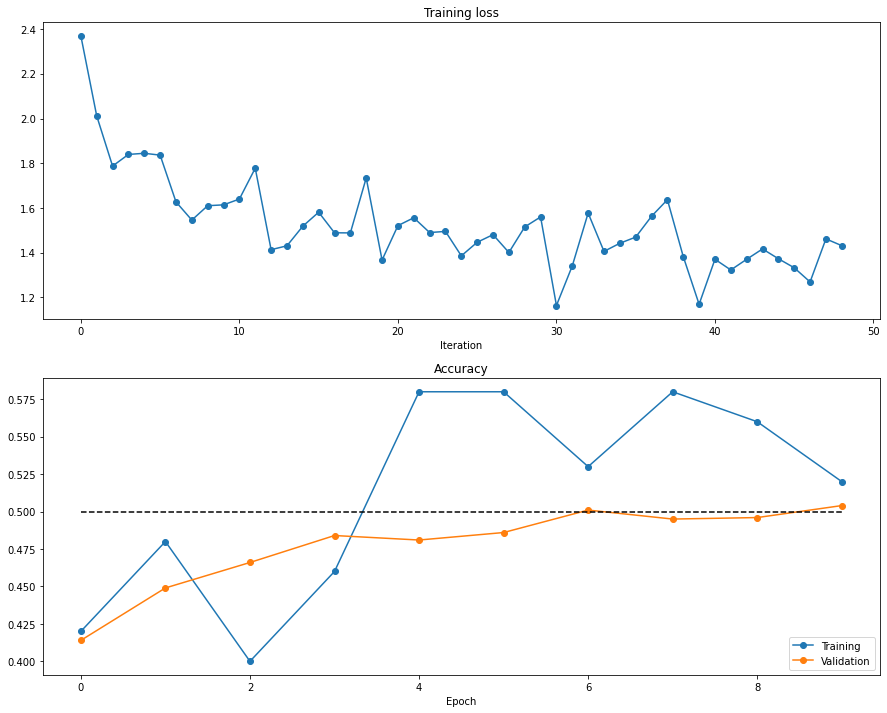

In [47]:
# Plot the learning curves
plt.subplot(2, 1, 1)
plt.title('Training loss')
loss_hist_ = loss_hist[1::100] # sparse the curve a bit
plt.plot(loss_hist_, '-o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_hist, '-o', label='Training')
plt.plot(val_acc_hist, '-o', label='Validation')
plt.plot([0.5] * len(val_acc_hist), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

## Different Optimizers
There are several more advanced optimizers than vanilla SGD, you will implement three more sophisticated and widely-used methods in this section.  
Please complete the TODOs in the `lib/optim.py`.

## SGD + Momentum [2pt]
The update rule of SGD plus momentum is as shown below:  
\begin{equation}
v_t: last\ update\ of\ the\ velocity \\
\gamma: momentum \\
\eta: learning\ rate \\
v_t = \gamma v_{t-1} - \eta \nabla_{\theta}J(\theta) \\
\theta = \theta + v_t
\end{equation}
Complete the `SGDM()` function in `lib/optim.py`.

In [54]:
%reload_ext autoreload

# Test the implementation of SGD with Momentum
seed = 123
np.random.seed(seed=seed)

N, D = 4, 5
test_sgd = sequential(fc(N, D, name="sgd_fc"))

w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

test_sgd.layers[0].params = {"sgd_fc_w": w}
test_sgd.layers[0].grads = {"sgd_fc_w": dw}

test_sgd_momentum = SGDM(test_sgd, 1e-3, 0.9)
test_sgd_momentum.velocity = {"sgd_fc_w": v}
test_sgd_momentum.step()

updated_w = test_sgd.layers[0].params["sgd_fc_w"]
velocity = test_sgd_momentum.velocity["sgd_fc_w"]

expected_updated_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print ('The following errors should be around or less than 1e-8')
print ('updated_w error: ', rel_error(updated_w, expected_updated_w))
print ('velocity error: ', rel_error(expected_velocity, velocity))

The following errors should be around or less than 1e-8
updated_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


## Comparing SGD and SGD with Momentum [2pt]
Run the following code block to train a multi-layer fully connected network with both SGD and SGD plus Momentum. The network trained with SGDM optimizer should converge faster.

Training with Vanilla SGD...
(Iteration 1 / 200) loss: 2.784078790273408
(Epoch 1 / 5) Training Accuracy: 0.34, Validation Accuracy: 0.262
(Epoch 2 / 5) Training Accuracy: 0.37, Validation Accuracy: 0.298
(Iteration 101 / 200) loss: 1.888878603563259
(Epoch 3 / 5) Training Accuracy: 0.36, Validation Accuracy: 0.296
(Epoch 4 / 5) Training Accuracy: 0.43, Validation Accuracy: 0.329
(Epoch 5 / 5) Training Accuracy: 0.53, Validation Accuracy: 0.315

Training with SGD plus Momentum...
(Iteration 1 / 200) loss: 2.4144157882454107
(Epoch 1 / 5) Training Accuracy: 0.32, Validation Accuracy: 0.296
(Epoch 2 / 5) Training Accuracy: 0.44, Validation Accuracy: 0.328
(Iteration 101 / 200) loss: 1.6831844456130503
(Epoch 3 / 5) Training Accuracy: 0.42, Validation Accuracy: 0.339
(Epoch 4 / 5) Training Accuracy: 0.48, Validation Accuracy: 0.336
(Epoch 5 / 5) Training Accuracy: 0.46, Validation Accuracy: 0.344


/opt/anaconda3/envs/dl_env/lib/python3.6/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/dl_env/lib/python3.6/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/dl_env/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

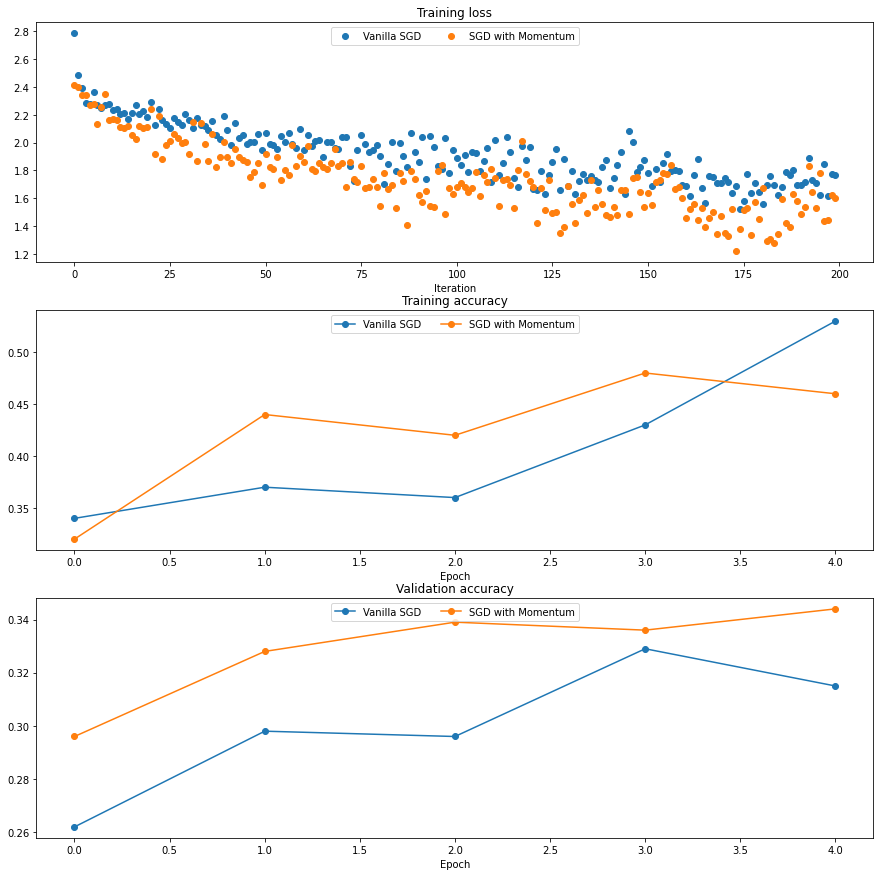

In [63]:
seed = 123
np.random.seed(seed=seed)

# Arrange a small data
num_train = 4000
small_data_dict = {
    "data_train": (data["data_train"][:num_train], data["labels_train"][:num_train]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

model_sgd      = FullyConnectedNetwork()
model_sgdm     = FullyConnectedNetwork()
loss_f_sgd     = cross_entropy()
loss_f_sgdm    = cross_entropy()
optimizer_sgd  = SGD(model_sgd.net, 1e-2)
optimizer_sgdm = SGDM(model_sgdm.net, 1e-2, 0.9)

print ("Training with Vanilla SGD...")
results_sgd = train_net(small_data_dict, model_sgd, loss_f_sgd, optimizer_sgd, batch_size=100, 
                        max_epochs=5, show_every=100, verbose=True)

print ("\nTraining with SGD plus Momentum...")
results_sgdm = train_net(small_data_dict, model_sgdm, loss_f_sgdm, optimizer_sgdm, batch_size=100, 
                         max_epochs=5, show_every=100, verbose=True)

opt_params_sgd,  loss_hist_sgd,  train_acc_hist_sgd,  val_acc_hist_sgd  = results_sgd
opt_params_sgdm, loss_hist_sgdm, train_acc_hist_sgdm, val_acc_hist_sgdm = results_sgdm

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgd, 'o', label="Vanilla SGD")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgd, '-o', label="Vanilla SGD")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgd, '-o', label="Vanilla SGD")
         
plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgdm, 'o', label="SGD with Momentum")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgdm, '-o', label="SGD with Momentum")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgdm, '-o', label="SGD with Momentum")
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## RMSProp [2pt]
The update rule of RMSProp is as shown below:  
\begin{equation}
\gamma: decay\ rate \\
\epsilon: small\ number \\
g_t^2: squared\ gradients \\
\eta: learning\ rate \\
E[g^2]_t: decaying\ average\ of\ past\ squared\ gradients\ at\ update\ step\ t \\
E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 \\
\theta_{t+1} = \theta_t - \frac{\eta \nabla_{\theta}J(\theta)}{\sqrt{E[g^2]_t+\epsilon}}
\end{equation}
Complete the `RMSProp()` function in `lib/optim.py`

In [72]:
%reload_ext autoreload

seed = 123
np.random.seed(seed=seed)

# Test RMSProp implementation; you should see errors less than 1e-7
N, D = 4, 5
test_rms = sequential(fc(N, D, name="rms_fc"))

w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

test_rms.layers[0].params = {"rms_fc_w": w}
test_rms.layers[0].grads = {"rms_fc_w": dw}

opt_rms = RMSProp(test_rms, 1e-2, 0.99)
opt_rms.cache = {"rms_fc_w": cache}
opt_rms.step()

updated_w = test_rms.layers[0].params["rms_fc_w"]
cache = opt_rms.cache["rms_fc_w"]

expected_updated_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print ('The following errors should be around or less than 1e-7')
print ('updated_w error: ', rel_error(expected_updated_w, updated_w))
print ('cache error: ', rel_error(expected_cache, opt_rms.cache["rms_fc_w"]))

The following errors should be around or less than 1e-7
updated_w error:  9.502645229894295e-08
cache error:  2.6477955807156126e-09


## Adam [2pt]
The update rule of Adam is as shown below:  
\begin{equation}
t = t + 1 \\
g_t: gradients\ at\ update\ step\ t \\
m_t = \beta_1m_{t-1} + (1-\beta_1)g_t \\
v_t = \beta_2v_{t-1} + (1-\beta_2)g_t^2 \\
\hat{m_t} = m_t / (1 - \beta_1^t) \\
\hat{v_t} = v_t / (1 - \beta_2^t) \\
\theta_{t+1} = \theta_t - \frac{\eta\ \hat{m_t}}{\sqrt{\hat{v_t}}+\epsilon} \\
\end{equation}
Complete the `Adam()` function in `lib/optim.py`

In [73]:
%reload_ext autoreload

seed = 123
np.random.seed(seed=seed)

# Test Adam implementation; you should see errors around 1e-7 or less
N, D = 4, 5
test_adam = sequential(fc(N, D, name="adam_fc"))

w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

test_adam.layers[0].params = {"adam_fc_w": w}
test_adam.layers[0].grads = {"adam_fc_w": dw}

opt_adam = Adam(test_adam, 1e-2, 0.9, 0.999, t=5)
opt_adam.mt = {"adam_fc_w": m}
opt_adam.vt = {"adam_fc_w": v}
opt_adam.step()

updated_w = test_adam.layers[0].params["adam_fc_w"]
mt = opt_adam.mt["adam_fc_w"]
vt = opt_adam.vt["adam_fc_w"]

expected_updated_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print ('The following errors should be around or less than 1e-7')
print ('updated_w error: ', rel_error(expected_updated_w, updated_w))
print ('mt error: ', rel_error(expected_m, mt))
print ('vt error: ', rel_error(expected_v, vt))

The following errors should be around or less than 1e-7
updated_w error:  1.1395691798535431e-07
mt error:  4.214963193114416e-09
vt error:  4.208314038113071e-09


## Comparing the optimizers [2pt]
Run the following code block to compare the plotted results among all the above optimizers. You should see SGD with Momentum, RMSProp, and Adam optimizers work better than Vanilla SGD optimizer.

Training with RMSProp...
(Iteration 1 / 200) loss: 2.784078790273408
(Epoch 1 / 5) Training Accuracy: 0.49, Validation Accuracy: 0.322
(Epoch 2 / 5) Training Accuracy: 0.59, Validation Accuracy: 0.367
(Iteration 101 / 200) loss: 1.7261488059097405
(Epoch 3 / 5) Training Accuracy: 0.55, Validation Accuracy: 0.365
(Epoch 4 / 5) Training Accuracy: 0.76, Validation Accuracy: 0.4
(Epoch 5 / 5) Training Accuracy: 0.68, Validation Accuracy: 0.348

Training with Adam...
(Iteration 1 / 200) loss: 2.4144157882454107
(Epoch 1 / 5) Training Accuracy: 0.4, Validation Accuracy: 0.294
(Epoch 2 / 5) Training Accuracy: 0.45, Validation Accuracy: 0.325
(Iteration 101 / 200) loss: 1.7290538183149777
(Epoch 3 / 5) Training Accuracy: 0.42, Validation Accuracy: 0.381
(Epoch 4 / 5) Training Accuracy: 0.46, Validation Accuracy: 0.385
(Epoch 5 / 5) Training Accuracy: 0.6, Validation Accuracy: 0.386


/opt/anaconda3/envs/dl_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/dl_env/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/dl_env/lib/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

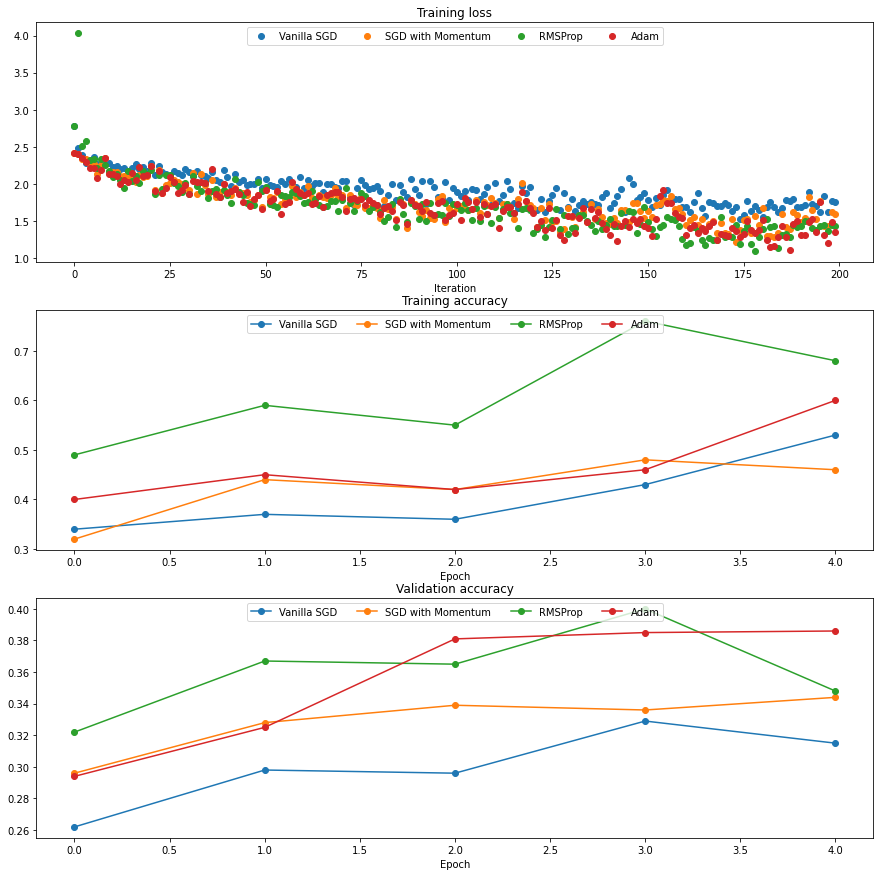

In [74]:
seed = 123
np.random.seed(seed=seed)

model_rms      = FullyConnectedNetwork()
model_adam     = FullyConnectedNetwork()
loss_f_rms     = cross_entropy()
loss_f_adam    = cross_entropy()
optimizer_rms  = RMSProp(model_rms.net, 5e-4)
optimizer_adam = Adam(model_adam.net, 5e-4)

print ("Training with RMSProp...")
results_rms = train_net(small_data_dict, model_rms, loss_f_rms, optimizer_rms, batch_size=100, 
                        max_epochs=5, show_every=100, verbose=True)

print ("\nTraining with Adam...")
results_adam = train_net(small_data_dict, model_adam, loss_f_adam, optimizer_adam, batch_size=100, 
                         max_epochs=5, show_every=100, verbose=True)

opt_params_rms,  loss_hist_rms,  train_acc_hist_rms,  val_acc_hist_rms  = results_rms
opt_params_adam, loss_hist_adam, train_acc_hist_adam, val_acc_hist_adam = results_adam

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgd, 'o', label="Vanilla SGD")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgd, '-o', label="Vanilla SGD")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgd, '-o', label="Vanilla SGD")
         
plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgdm, 'o', label="SGD with Momentum")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgdm, '-o', label="SGD with Momentum")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgdm, '-o', label="SGD with Momentum")

plt.subplot(3, 1, 1)
plt.plot(loss_hist_rms, 'o', label="RMSProp")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_rms, '-o', label="RMSProp")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_rms, '-o', label="RMSProp")
         
plt.subplot(3, 1, 1)
plt.plot(loss_hist_adam, 'o', label="Adam")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_adam, '-o', label="Adam")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_adam, '-o', label="Adam")
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Training a Network with Dropout [2pt]
Run the following code blocks to compare the results with and without dropout

In [75]:
# Train two identical nets, one with dropout and one without
num_train = 100
data_dict_100 = {
    "data_train": (data["data_train"][:num_train], data["labels_train"][:num_train]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

solvers = {}
keep_ps = [0, 0.25, 0.50, 0.75]

results_dict = {}
for keep_prob in keep_ps:
    results_dict[keep_prob] = {}

for keep_prob in keep_ps:
    seed = 123
    np.random.seed(seed=seed)

    print ("Dropout Keep Prob =", keep_prob)
    model = DropoutNetTest(keep_prob=keep_prob)
    loss_f = cross_entropy()
    optimizer = SGD(model.net, 1e-4)
    results = train_net(data_dict_100, model, loss_f, optimizer, batch_size=20, 
                        max_epochs=50, show_every=1000, verbose=True)
    opt_params, loss_hist, train_acc_hist, val_acc_hist = results
    results_dict[keep_prob] = {
        "opt_params": opt_params, 
        "loss_hist": loss_hist, 
        "train_acc_hist": train_acc_hist, 
        "val_acc_hist": val_acc_hist
    }

Dropout Keep Prob = 0
(Iteration 1 / 250) loss: 2.8714007645507165
(Epoch 1 / 50) Training Accuracy: 0.2, Validation Accuracy: 0.089
(Epoch 2 / 50) Training Accuracy: 0.25, Validation Accuracy: 0.105
(Epoch 3 / 50) Training Accuracy: 0.1, Validation Accuracy: 0.117
(Epoch 4 / 50) Training Accuracy: 0.3, Validation Accuracy: 0.126
(Epoch 5 / 50) Training Accuracy: 0.2, Validation Accuracy: 0.127
(Epoch 6 / 50) Training Accuracy: 0.4, Validation Accuracy: 0.135
(Epoch 7 / 50) Training Accuracy: 0.25, Validation Accuracy: 0.134
(Epoch 8 / 50) Training Accuracy: 0.55, Validation Accuracy: 0.138
(Epoch 9 / 50) Training Accuracy: 0.6, Validation Accuracy: 0.143
(Epoch 10 / 50) Training Accuracy: 0.35, Validation Accuracy: 0.146
(Epoch 11 / 50) Training Accuracy: 0.4, Validation Accuracy: 0.147
(Epoch 12 / 50) Training Accuracy: 0.45, Validation Accuracy: 0.153
(Epoch 13 / 50) Training Accuracy: 0.45, Validation Accuracy: 0.152
(Epoch 14 / 50) Training Accuracy: 0.65, Validation Accuracy: 0.1

(Epoch 21 / 50) Training Accuracy: 0.6, Validation Accuracy: 0.179
(Epoch 22 / 50) Training Accuracy: 0.55, Validation Accuracy: 0.171
(Epoch 23 / 50) Training Accuracy: 0.65, Validation Accuracy: 0.18
(Epoch 24 / 50) Training Accuracy: 0.6, Validation Accuracy: 0.186
(Epoch 25 / 50) Training Accuracy: 0.8, Validation Accuracy: 0.184
(Epoch 26 / 50) Training Accuracy: 0.75, Validation Accuracy: 0.191
(Epoch 27 / 50) Training Accuracy: 0.7, Validation Accuracy: 0.19
(Epoch 28 / 50) Training Accuracy: 0.85, Validation Accuracy: 0.19
(Epoch 29 / 50) Training Accuracy: 0.75, Validation Accuracy: 0.192
(Epoch 30 / 50) Training Accuracy: 0.8, Validation Accuracy: 0.195
(Epoch 31 / 50) Training Accuracy: 0.75, Validation Accuracy: 0.197
(Epoch 32 / 50) Training Accuracy: 0.8, Validation Accuracy: 0.192
(Epoch 33 / 50) Training Accuracy: 0.75, Validation Accuracy: 0.199
(Epoch 34 / 50) Training Accuracy: 0.75, Validation Accuracy: 0.199
(Epoch 35 / 50) Training Accuracy: 0.7, Validation Accura

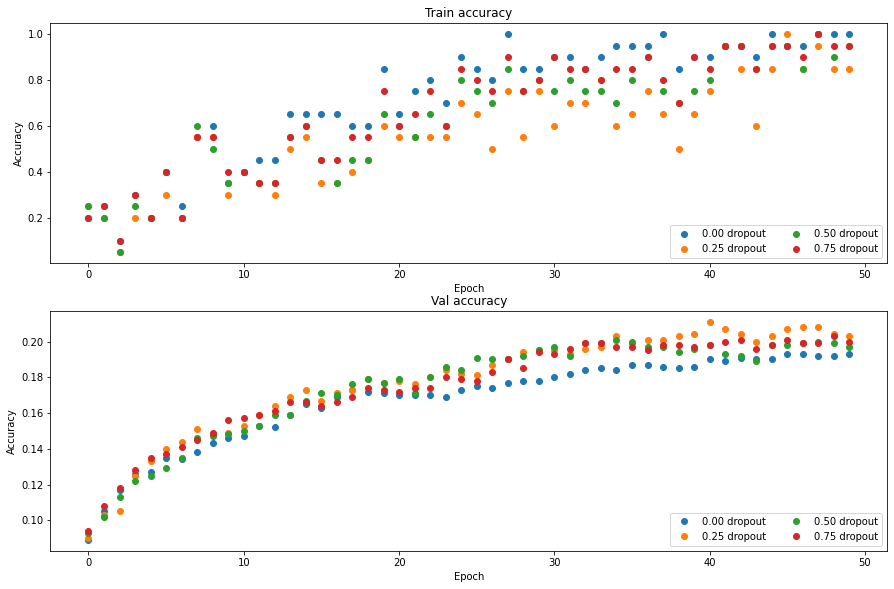

In [76]:
# Plot train and validation accuracies of the two models
train_accs = []
val_accs = []
for keep_prob in keep_ps:
    curr_dict = results_dict[keep_prob]
    train_accs.append(curr_dict["train_acc_hist"][-1])
    val_accs.append(curr_dict["val_acc_hist"][-1])

plt.subplot(3, 1, 1)
for keep_prob in keep_ps:
    curr_dict = results_dict[keep_prob]
    plt.plot(curr_dict["train_acc_hist"], 'o', label='%.2f dropout' % keep_prob)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for keep_prob in keep_ps:
    curr_dict = results_dict[keep_prob]
    plt.plot(curr_dict["val_acc_hist"], 'o', label='%.2f dropout' % keep_prob)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

### Inline Question: Describe what you observe from the above results and graphs about dropout + give an explanation. [2pt]

(Please limit your answer to <100 words)

#### Ans: 0 dropout has the best accuracy at traning time in most epochs and 0.25 has worst accuracy. The opposite happens at validation time accuracy improves when 0.25 and 0.75 keep_prob is added

## Plot the Activation Functions [1pt]
In each of the activation function, use the given lambda function template to plot their corresponding curves.

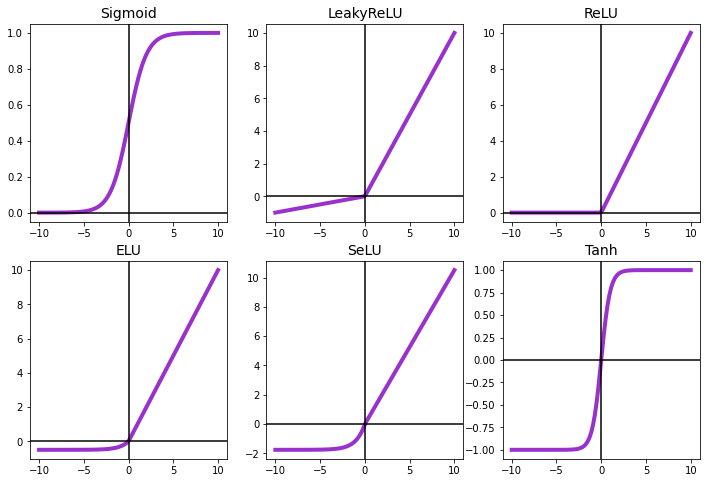

In [87]:
left, right = -10, 10
X  = np.linspace(left, right, 100)
XS = np.linspace(-5, 5, 10)
lw = 4
alpha = 0.1 # alpha for leaky_relu
elu_alpha = 0.5
selu_alpha = 1.6732
selu_scale = 1.0507

###################
# TODO: YOUR CODE #
###################
sigmoid = lambda x: 1 / (1 + np.exp(-x))
leaky_relu = lambda x: np.where(alpha * x < x, x, alpha * x)
relu = lambda x: np.where(0 < x, x, 0)
elu = lambda x: np.where(x >= 0, x, elu_alpha * (np.exp(x) - 1))
selu = lambda x: selu_scale * np.where(x >= 0, x, selu_alpha * (np.exp(x) - 1))
tanh = lambda x: np.tanh(x)
####################
# END OF YOUR CODE #
####################

activations = {
    "Sigmoid": sigmoid,
    "LeakyReLU": leaky_relu,
    "ReLU": relu,
    "ELU": elu,
    "SeLU": selu,
    "Tanh": tanh
}

# Ground Truth activations
GT_Act = {
    "Sigmoid": [0.00669285092428, 0.0200575365379, 0.0585369028744, 0.158869104881, 0.364576440742, 
                0.635423559258, 0.841130895119, 0.941463097126, 0.979942463462, 0.993307149076],
    "LeakyReLU": [-0.5, -0.388888888889, -0.277777777778, -0.166666666667, -0.0555555555556, 
                  0.555555555556, 1.66666666667, 2.77777777778, 3.88888888889, 5.0],
    "ReLU": [-0.0, -0.0, -0.0, -0.0, -0.0, 0.555555555556, 1.66666666667, 2.77777777778, 3.88888888889, 5.0],
    "ELU": [-0.4966310265, -0.489765962143, -0.468911737989, -0.405562198581, -0.213123289631, 
            0.555555555556, 1.66666666667, 2.77777777778, 3.88888888889, 5.0],
    "SeLU": [-1.74618571868, -1.72204772347, -1.64872296837, -1.42598202974, -0.749354802287, 
             0.583722222222, 1.75116666667, 2.91861111111, 4.08605555556, 5.2535],
    "Tanh": [-0.999909204263, -0.999162466631, -0.992297935288, -0.931109608668, -0.504672397722, 
             0.504672397722, 0.931109608668, 0.992297935288, 0.999162466631, 0.999909204263]
} 

fig = plt.figure(figsize=(12,8))
for i, label in enumerate(activations):
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(X, activations[label](X), color='darkorchid', lw=lw, label=label)
    assert rel_error(activations[label](XS), GT_Act[label]) < 1e-9, \
           "Your implementation of {} might be wrong".format(label)
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_title('{}'.format(label), fontsize=14)
plt.show()

# Submission

Please prepare a PDF document `problem_1_solution.pdf` in the root directory of this repository with all plots and inline answers of your solution. Concretely, the document should contain the following items in strict order:
1. Training loss / accuracy curves for the simple neural network training with >50% validation accuracy
2. Plots for comparing vanilla SGD to SGD + Momentum
3. "Comparing different Optimizers" plots
4. Dropout comparison plots
5. Dropout inline question answer
6. Activation function plot

Note that you still need to submit the jupyter notebook with all generated solutions. We will randomly pick submissions and check that the plots in the PDF and in the notebook are equivalent.